Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd
print("pandas: ", pd.__version__)
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)

pandas:  1.1.0
torch:  1.6.0
numpy:  1.19.1


In [2]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

wsubuntu_khs_dir = /home/wsubuntu/GitHub/keyhandshapediscovery
wsubuntu_data_path = /media/wsubuntu/SSD_Data/DataPath
wsubuntu_experiment_path = /media/wsubuntu/SSD_Data/vaesae_experiments


In [3]:
sys.path.insert(1, khs_dir)
import helperFuncs as funcH

In [4]:
EXPERIMENT_ID = 28
LOSS_TYPE='cre'
LOSS_REDUCTION='mean' #'batchmean','sum'
SIGMOID_ACT=True
APPLY_LOG_SOFTMAX=False
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [5]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

In [6]:
#ap = argparse.ArgumentParser()
#ap.add_argument('-e', '--epochs', type=int, default=10, help='number of epochs to train our network for')
#ap.add_argument('-l', '--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
#ap.add_argument('-sc', '--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
#args = vars(ap.parse_args())
epochs = 100  # args['epochs']
reg_param = 1  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [7]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


In [8]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [9]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=32)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=32, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()
        print("SparseAutoencoder - loss_type(" + loss_type +"), device(" + self.device + ")")

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        #if self.loss_type=='cre':
        #    bottleneck = self.enc5(x) 
        #else:
        bottleneck = F.relu(self.enc5(x))  
        
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        #if self.loss_type=='cre':
        #    x = F.relu(self.dec1(F.relu(bottleneck)))
        #else:
        x = F.relu(self.dec1(bottleneck))
        
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

SparseAutoencoder - loss_type(cre), device(cpu)


In [10]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [12]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    rho_val = 1/bt.size(1)
    rho_mat = torch.tensor([rho_val] * np.ones(bt.size()), dtype=torch.float32).to(device)
    #https://discuss.pytorch.org/t/kl-divergence-produces-negative-values/16791/13
    #KLDLoss(p, q), sum(q) needs to equal one
    #p = log_softmax(tensor)
    loss_ret_1 = F.kl_div(F.log_softmax(bt, dim=1).to(device), rho_mat, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1


def loss_crossentropy(bottleneck, sigmoidAct, reduction, apply_log_softmax, print_info):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct and apply_log_softmax:  
        if print_info:
            print("1-",sigmoidAct,apply_log_softmax)
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
        _, preds = torch.max(bt, 1)
        loss_ret_1 = loss_fun(F.log_softmax(bt, dim=1).to(device), preds)    
    elif sigmoidAct and not apply_log_softmax:     
        if print_info:
            print("2-",sigmoidAct,apply_log_softmax)
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
        _, preds = torch.max(bt, 1)
        loss_ret_1 = loss_fun(bt.to(device), preds)    
    elif not sigmoidAct and apply_log_softmax:
        if print_info:
            print("3-",sigmoidAct,apply_log_softmax)
        _, preds = torch.max(bottleneck, 1)
        loss_ret_1 = loss_fun(F.log_softmax(bottleneck, dim=1).to(device), preds)    
    else:#nothing
        if print_info:
            print("4-",sigmoidAct,apply_log_softmax)
        _, preds = torch.max(bottleneck, 1)
        loss_ret_1 = loss_fun(bottleneck.to(device), preds)
    return loss_ret_1

def loss_crossentropy_old(bottleneck, sigmoidAct, reduction, apply_log_softmax, print_info):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    else:
        bt = bottleneck    
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(F.log_softmax(bt, dim=1).to(device), preds)    
    return loss_ret_1

In [13]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
    if print_info:
        print(loss_type,loss)
    return loss

In [14]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [15]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [16]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_LOG_SOFTMAX : ", APPLY_LOG_SOFTMAX)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param("+ str(reg_param) +") * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws :: 
EXPERIMENT_ID:  28
LOSS_TYPE :  cre
LOSS_REDUCTION :  mean
SIGMOID_ACT :  True
APPLY_LOG_SOFTMAX :  False
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param(1) * sp_loss
*****
 Epoch 0 of 100
TrEpoch(000) - 2- True False
cre tensor(3.4291, grad_fn=<AddBackward0>)
sp_loss: 3.4291458129882812

     acc      bmx  bmn      mse       spr      run
0  10.0  102.452  0.0  194.376  5623.894  5818.27
ValEpoch(000) - 
     acc      bmx  bmn     run
0  10.0  101.685  0.0  29.514
*****
 Epoch 1 of 100
TrEpoch(001) - 
     acc      bmx  bmn      mse       spr       run
0  10.0  202.163  0.0  166.368  5598.558  5764.926
ValEpoch(001) - 
     acc      bmx  bmn     run
0  10.0  199.356  0.0  25.309
*****
 Epoch 2 of 100
TrEpoch(002) - 
     acc      bmx  bmn      mse     spr       run
0  10.0  233.377  0.0  147.307  5598.5  5745.807
ValEpoch(002) - 
     acc      bmx  bmn     run
0  10.0  196.136  0.0  23.884
*****
 Epoch 3 of 100
TrEpoch(003) - 
     acc      bmx  bmn     ms

TrEpoch(034) - 
     acc      bmx  bmn     mse       spr       run
0  10.0  181.443  0.0  98.998  5598.462  5697.461
ValEpoch(034) - 
     acc      bmx  bmn     run
0  10.0  172.188  0.0  16.912
*****
 Epoch 35 of 100
TrEpoch(035) - 
     acc      bmx  bmn    mse      spr       run
0  10.0  175.851  0.0  99.03  5598.46  5697.489
ValEpoch(035) - 
     acc     bmx  bmn     run
0  10.0  183.72  0.0  16.697
*****
 Epoch 36 of 100
TrEpoch(036) - 2- True False
cre tensor(2.9858, grad_fn=<AddBackward0>)
sp_loss: 2.9858267307281494

     acc      bmx  bmn    mse       spr       run
0  10.0  175.904  0.0  98.69  5598.464  5697.153
ValEpoch(036) - 
     acc      bmx  bmn     run
0  10.0  175.192  0.0  16.728
*****
 Epoch 37 of 100
TrEpoch(037) - 
     acc      bmx  bmn     mse       spr       run
0  10.0  178.953  0.0  98.256  5598.467  5696.723
ValEpoch(037) - 
     acc      bmx  bmn     run
0  10.0  181.116  0.0  16.636
*****
 Epoch 38 of 100
TrEpoch(038) - 
     acc      bmx  bmn     mse     

TrEpoch(069) - 
     acc      bmx  bmn     mse       spr       run
0  10.0  176.196  0.0  91.461  5598.468  5689.929
ValEpoch(069) - 
     acc      bmx  bmn     run
0  10.0  174.538  0.0  15.331
*****
 Epoch 70 of 100
TrEpoch(070) - 
     acc      bmx  bmn     mse       spr       run
0  10.0  176.097  0.0  92.021  5598.454  5690.475
ValEpoch(070) - 
     acc      bmx  bmn     run
0  10.0  187.011  0.0  15.769
*****
 Epoch 71 of 100
TrEpoch(071) - 2- True False
cre tensor(2.9858, grad_fn=<AddBackward0>)
sp_loss: 2.985813617706299

     acc      bmx  bmn     mse       spr       run
0  10.0  179.619  0.0  91.625  5598.461  5690.085
ValEpoch(071) - 
     acc      bmx  bmn     run
0  10.0  177.775  0.0  15.314
*****
 Epoch 72 of 100
TrEpoch(072) - 
     acc      bmx  bmn     mse       spr       run
0  10.0  179.656  0.0  91.229  5598.476  5689.705
ValEpoch(072) - 
     acc      bmx  bmn     run
0  10.0  175.861  0.0  15.147
*****
 Epoch 73 of 100
TrEpoch(073) - 
     acc      bmx  bmn     m

In [17]:
print(result_df_tr_all)

       acc      bmx  bmn      mse       spr       run
0   10.000  102.452  0.0  194.376  5623.894  5818.270
1   10.000  202.163  0.0  166.368  5598.558  5764.926
2   10.000  233.377  0.0  147.307  5598.500  5745.807
3   10.000  196.937  0.0  138.410  5598.480  5736.890
4   10.000  151.130  0.0  132.619  5598.471  5731.091
5   10.000  138.199  0.0  129.156  5598.450  5727.606
6   10.000  133.038  0.0  125.683  5598.444  5724.127
7   10.000  129.645  0.0  124.163  5598.441  5722.604
8   10.000  128.514  0.0  121.373  5598.448  5719.821
9   10.000  134.024  0.0  119.090  5598.451  5717.540
10  10.000  136.412  0.0  116.736  5598.457  5715.192
11  10.000  141.398  0.0  115.188  5598.464  5713.652
12  10.000  149.386  0.0  114.342  5598.470  5712.812
13  10.000  145.646  0.0  113.556  5598.465  5712.021
14  10.000  148.594  0.0  111.740  5598.466  5710.206
15  10.000  150.574  0.0  111.245  5598.459  5709.703
16  10.000  151.347  0.0  110.698  5598.468  5709.166
17  10.000  153.411  0.0  11

In [18]:
print(result_df_va_all)

     acc      bmx  bmn     run
0   10.0  101.685  0.0  29.514
1   10.0  199.356  0.0  25.309
2   10.0  196.136  0.0  23.884
3   10.0  159.821  0.0  22.418
4   10.0  136.787  0.0  21.826
5   10.0  131.652  0.0  21.390
6   10.0  123.893  0.0  20.822
7   10.0  122.864  0.0  20.554
8   10.0  121.303  0.0  20.028
9   10.0  130.614  0.0  19.647
10  10.0  132.433  0.0  19.455
11  10.0  133.137  0.0  19.121
12  10.0  140.881  0.0  19.069
13  10.0  141.923  0.0  18.950
14  10.0  139.418  0.0  18.632
15  10.0  145.865  0.0  18.619
16  10.0  147.173  0.0  18.531
17  10.0  146.336  0.0  18.452
18  10.0  150.904  0.0  18.557
19  10.0  148.644  0.0  18.195
20  10.0  149.843  0.0  18.041
21  10.0  156.024  0.0  17.985
22  10.0  156.929  0.0  17.867
23  10.0  161.137  0.0  17.922
24  10.0  160.408  0.0  17.665
25  10.0  162.972  0.0  17.466
26  10.0  167.821  0.0  17.425
27  10.0  168.761  0.0  17.674
28  10.0  168.776  0.0  17.132
29  10.0  171.114  0.0  17.129
30  10.0  169.675  0.0  17.026
31  10.0

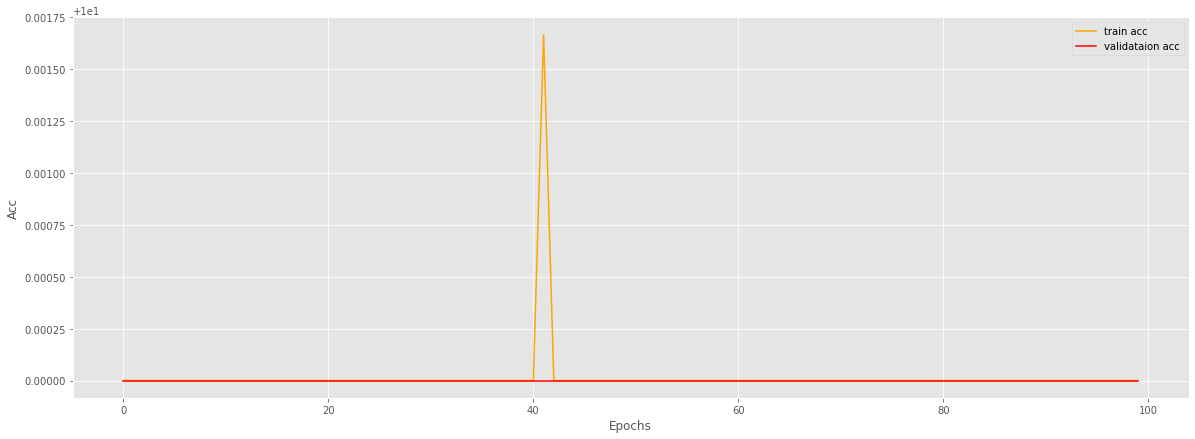

Max tr acc =  10.001666666666667
Max va acc =  10.0


In [19]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

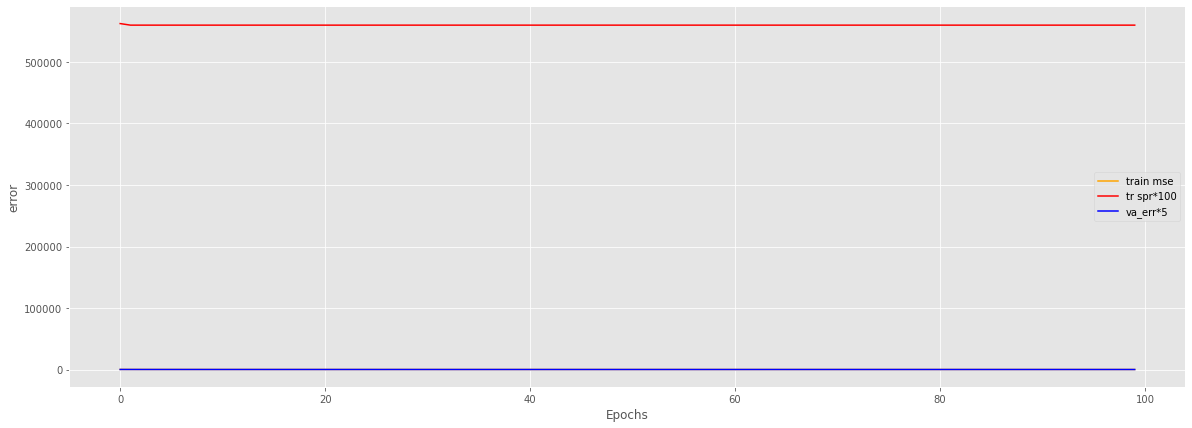

In [20]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr_50 = 100*result_df_tr_all.values[:,4].squeeze()
va_err = 5*result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse, color='orange', label='train mse')
plt.plot(tr_spr_50, color='red', label='tr spr*100')
plt.plot(va_err, color='blue', label='va_err*5')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()